## Обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Conv2D, Input, Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras.losses import categorical_crossentropy

Загрузим тренировочный и тестовый датасеты

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Конвертируем числа во float

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

Нормализуем данные, проведем OHE и приведем размерность в 4D массив

In [5]:
x_train /= 255 
x_test /= 255 

y_train = to_categorical(y_train, 10) 
y_test = to_categorical(y_test, 10) 

x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

Классы изображений

In [6]:
labels = {
        0: 'футболка',
        1: 'брюки',
        2: 'свитер',
        3: 'платье',
        4: 'куртка',
        5: 'сандалии',
        6: 'рубашка',
        7: 'кроссовки',
        8: 'сумка',
        9: 'ботинки',
            }

Пример из датасета

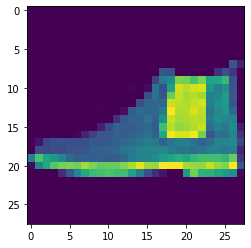

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Это ботинки


In [7]:
N = 111
plt.imshow(x_train[N,:,:])
plt.show()
label = np.argmax(y_train[N], axis = 0)
print(y_train[N])
print(f'Это {labels[label]}')

Размерность набора данных для обучения

In [8]:
x_train.shape

(60000, 28, 28, 1)

Соберем нейронку

In [9]:
batch_size=32
epochs = 5
num_predictions = 20
results = []
name='base_model'

In [10]:
# конфигурирование слоев нейросети
model = Sequential(name=name)

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels)))
model.add(Activation('softmax'))

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              verbose=0)

In [11]:
model.summary()

Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        1

Сохраним модель и веса

In [12]:
model_path = os.path.join('Models', name)
model.save(model_path)
print(f'Сохранили модель: {model_path}')

INFO:tensorflow:Assets written to: Models/base_model/assets
Сохранили модель: Models/base_model


Проверим работу модели

In [13]:
# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 6s 21ms/step - loss: 0.4058 - accuracy: 0.8489
Test loss: 0.4058495759963989
Test accuracy: 0.8489000201225281


Сделаем предикт для примеров тестов

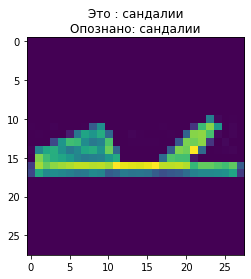

In [14]:
N = 111
y_p=model.predict(x_test[N:N+1][:,:,:])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(x_test[N][:,:,:])
plt.title(f'Это : {labels[y_t[0]]}\nОпознано: {labels[y_i[0]]}')
plt.show()

## Оценить рост точности при увеличении ширины сети (больше ядер)

In [15]:
kernel_color = {2: 'red', 4: 'blue', 8: 'green', 16: 'orange', 32: 'chocolate', 64: 'plum'}

2_kernel_model
Test loss: 0.5971868634223938
Test accuracy: 0.779699981212616
4_kernel_model
Test loss: 0.5031704306602478
Test accuracy: 0.8180000185966492
8_kernel_model
Test loss: 0.44314810633659363
Test accuracy: 0.8396999835968018
16_kernel_model
Test loss: 0.3972049653530121
Test accuracy: 0.8547000288963318
32_kernel_model
Test loss: 0.3823026418685913
Test accuracy: 0.859499990940094
64_kernel_model
Test loss: 0.3662382960319519
Test accuracy: 0.8652999997138977


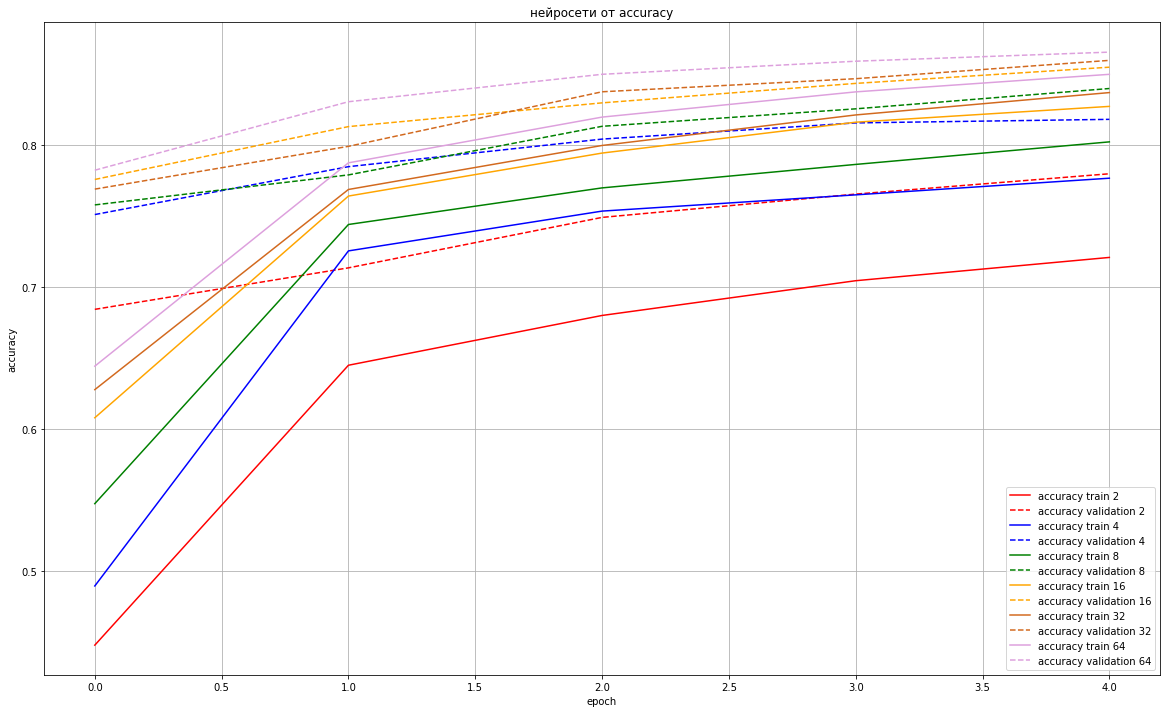

In [16]:
plt.figure(figsize=(20,12))

for k, c in kernel_color.items():
    name=f'{k}_kernel_model'
    print(name)
    model = Sequential(name=name)

    # слои, отвественные за свертку и max-pooling
    model.add(Conv2D(k, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(k, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout( 0.25))

    model.add(Conv2D(2*k, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(2*k, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # полносвязные слои
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(labels)))
    model.add(Activation('softmax'))

    # компиляция модели
    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])

    model_history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  verbose=0)
    
    scores = model.evaluate(x_test, y_test, verbose=0)
    results.append([name, scores[0], scores[1]])
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    
    plt.plot(model_history.history['accuracy'], color=c, linestyle='-', label = f'accuracy train {k}')
    plt.plot(model_history.history['val_accuracy'], color=c, linestyle='--', label = f'accuracy validation {k}')
        
plt.legend()
plt.grid('On')
plt.title('нейросети от accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [17]:
pd.DataFrame(results, columns=['name', 'test loss', 'test accuracy']).sort_values(by='test accuracy')

,name,test loss,test accuracy
0,2_kernel_model,0.597187,0.7797
1,4_kernel_model,0.503170,0.8180
2,8_kernel_model,0.443148,0.8397
3,16_kernel_model,0.397205,0.8547
4,32_kernel_model,0.382303,0.8595
5,64_kernel_model,0.366238,0.8653


По графику четко видно, что с ростом количества ядер растет и точность

## Оценить рост точности при увеличении глубины сети (больше слоев)

Значения accuracy в предыдущем эксперименте после 16 ядер росло незначительно, поэтому примем это значение для следующего эксперимента.

In [18]:
stack_colors = {1: 'green', 2: 'orange', 3: 'chocolate'}
kernel = 16
results_depth = []

1_stack_model
Test loss: 0.36219173669815063
Test accuracy: 0.8687000274658203
2_stack_model
Test loss: 0.40230950713157654
Test accuracy: 0.8539999723434448
3_stack_model
Test loss: 0.5139217972755432
Test accuracy: 0.8033999800682068


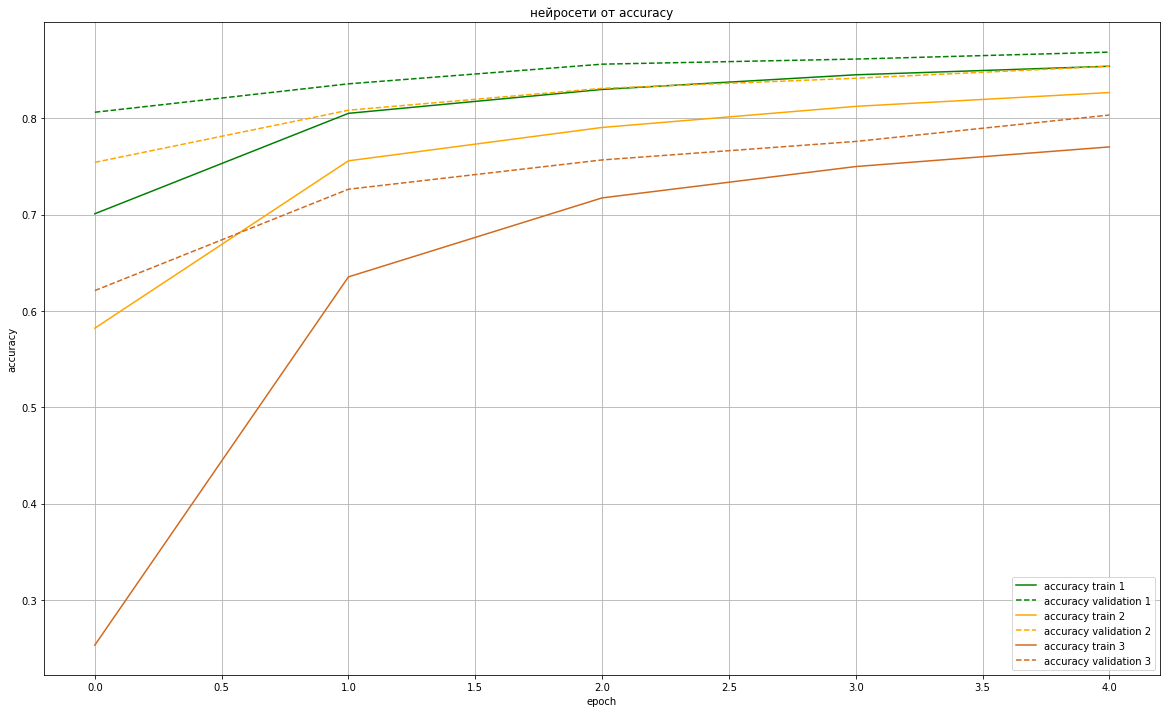

In [19]:
plt.figure(figsize=(20,12))

for stack, c in stack_colors.items():
    name=f'{stack}_stack_model'
    print(name)
    model = Sequential(name=name)
    for n in range(stack):
        # слои нейросети отвественные за свертку и max-pooling
        model.add(Conv2D(kernel*(2**n), (3, 3), padding='same',
                         input_shape=x_train.shape[1:]))
        model.add(Activation('relu'))
        model.add(Conv2D(kernel*(2**n), (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout( 0.25))

    # полносвязные слои нейронной сети
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(labels)))
    model.add(Activation('softmax'))
    
    # компиляция модели
    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])

    model_history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  verbose=0)
    
    scores = model.evaluate(x_test, y_test, verbose=0)
    results_depth.append([name, scores[0], scores[1]])
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    
    plt.plot(model_history.history['accuracy'], color=c, linestyle='-', label = f'accuracy train {stack}')
    plt.plot(model_history.history['val_accuracy'], color=c, linestyle='--', label = f'accuracy validation {stack}')
        
plt.legend()
plt.grid('On')
plt.title('нейросети от accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [20]:
pd.DataFrame(results_depth, columns=['name', 'test loss', 'test accuracy']).sort_values(by='test accuracy')

,name,test loss,test accuracy
2,3_stack_model,0.513922,0.8034
1,2_stack_model,0.402310,0.8540
0,1_stack_model,0.362192,0.8687


Здесь лучшие результаты были показаны при одном стеке.

## Сравнить с точностью полносвязной сети для этой выборки

Возьмем лучшие параметры (1 стек и 64 ядра) и сформируем для нее матрицу ошибок.

In [21]:
kernrl = 64
epochs = 15

name='result_model'
print(name)
model = Sequential(name=name)

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(kernel, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(kernel, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels)))
model.add(Activation('softmax'))

model.summary()

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

model_history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              verbose=0)

scores = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

result_model
Model: "result_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
activation_60 (Activation)   (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 26, 26, 16)        2320      
_________________________________________________________________
activation_61 (Activation)   (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 13, 13, 16)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2704)

In [22]:
predictions = model.predict(x_test)

y_predict = np.argmax(predictions, axis=1)

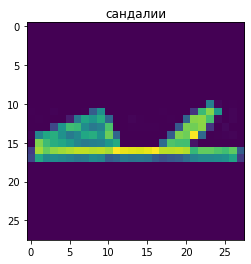

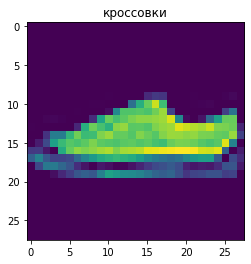

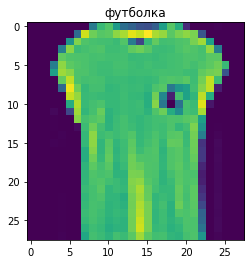

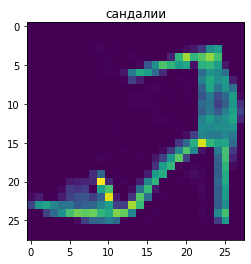

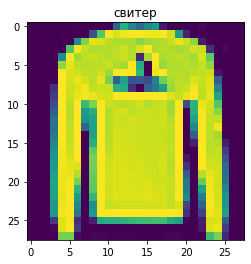

In [23]:
for n in (111, 112, 113, 114, 115):
    plt.imshow(x_test[n,:,:])
    plt.title(labels[y_predict[n]])
    plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_predict)
cnf_matrix

array([[839,   0,  18,  24,   4,   1, 108,   0,   6,   0],
       [  2, 974,   0,  17,   3,   0,   3,   0,   1,   0],
       [ 10,   0, 829,   9,  82,   0,  70,   0,   0,   0],
       [  9,   4,   8, 914,  31,   0,  30,   0,   4,   0],
       [  1,   1,  48,  31, 873,   0,  45,   0,   1,   0],
       [  0,   0,   0,   1,   0, 971,   0,  19,   1,   8],
       [ 98,   0,  74,  24,  83,   0, 712,   0,   9,   0],
       [  0,   0,   0,   0,   0,   8,   0, 975,   1,  16],
       [  2,   2,   4,   6,   5,   1,   4,   5, 971,   0],
       [  0,   0,   0,   0,   0,   6,   1,  37,   0, 956]])

In [25]:
report = classification_report(np.argmax(y_test, axis=1), y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1000
           1       0.99      0.97      0.98      1000
           2       0.85      0.83      0.84      1000
           3       0.89      0.91      0.90      1000
           4       0.81      0.87      0.84      1000
           5       0.98      0.97      0.98      1000
           6       0.73      0.71      0.72      1000
           7       0.94      0.97      0.96      1000
           8       0.98      0.97      0.97      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [26]:
store -r report_hw2

In [27]:
print(report_hw2)

              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1000
           1       1.00      0.95      0.98      1000
           2       0.83      0.75      0.79      1000
           3       0.84      0.93      0.88      1000
           4       0.77      0.86      0.81      1000
           5       0.91      0.97      0.94      1000
           6       0.65      0.75      0.70      1000
           7       0.96      0.89      0.92      1000
           8       0.97      0.96      0.96      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



Выводы: сверточная сеть дала лучшие результаты по показателям accuracy, macro avg, weighted avg.